In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
from PIL import Image, ImageOps
import cv2
from scipy import cluster
from sklearn.preprocessing import MinMaxScaler
import imagesize
import random
from sklearn.preprocessing import LabelEncoder
from ipywidgets import interact
import time
from io import BytesIO
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
from keras.metrics import Precision, Recall, Accuracy
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from math import ceil

In [12]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [13]:
!git clone -b preproc_package https://github.com/orlandoalexander/Moda-Personal-Assistant.git

Cloning into 'Moda-Personal-Assistant'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 377 (delta 67), reused 96 (delta 27), pack-reused 207
Receiving objects: 100% (377/377), 90.29 MiB | 24.53 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [14]:
%cd Moda-Personal-Assistant
! pip install .

/content/Moda-Personal-Assistant
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/Moda-Personal-Assistant
  Preparing metadata (setup.py) ... done
  Using cached flatbuffers-22.12.6-py2.py3-none-any.whl (26 kB)
  Using cached google_auth-2.15.0-py2.py3-none-any.whl (177 kB)
  Using cached grpcio-1.51.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
  Using cached h5py-3.7.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.5 MB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached importlib_metadata-5.1.0-py3-none-any.whl (21 kB)
  Using cached MarkupSafe-2.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 33.5 MB/s eta 0:00:00
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached scikit_learn-1.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)
  Using cached six-1.

In [15]:
!pwd 


/content/Moda-Personal-Assistant


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Load raw data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip '/content/drive/MyDrive/Le Wagon/Moda-Personal-Assistant/Data/DeepFashion_categorical_images_low/img.zip'

In [ ]:
PATH_IMG = '/content/img/'
PATH_DATA = '/content/drive/MyDrive/Le Wagon/Moda-Personal-Assistant/Data/DeepFashion_attributes - train'


In [ ]:
cat_names = pd.read_csv(PATH_DATA+'/list_category.txt',sep ='\s+',header=None).reset_index().rename(columns={0:'category',1:'section','index':'cat_num'})


In [ ]:
cat_names['cat_num'] = cat_names['cat_num'].apply(lambda x : x+1)

In [ ]:
cat_names.head()

,cat_num,category,section
0,1,Anorak,1
1,2,Blazer,1
2,3,Blouse,1
3,4,Bomber,1
4,5,Button-Down,1


In [ ]:
cat_tag = pd.read_csv(PATH_DATA+'/tag_cat_simple.txt',sep='\s+',header=None,names=['category']).rename(columns={'category':'cat_num'})



In [ ]:
cat_img = pd.read_csv(PATH_DATA+'/img_simple.txt',sep='\s+',header=None,names=['category']).rename(columns={'category':'img'})

In [ ]:
cat_num = cat_img.join(cat_tag).drop(columns='img')


In [ ]:
cat_num.head()

,cat_num
0,3
1,33
2,41
3,26
4,2


In [ ]:
cat = cat_num.merge(cat_names, on='cat_num', how='left').drop(columns='cat_num')



In [ ]:
cat

,category,section
0,Blouse,1
1,Skirt,2
2,Dress,3
3,Jeans,2
4,Blazer,1
...,...,...
19995,Tank,1
19996,Sweater,1
19997,Henley,1
19998,Jumpsuit,3


In [ ]:
cat['section'] = cat['section'].map({1:'upper',2:'lower',3:'full body'})

In [ ]:
cat_names = pd.read_csv(PATH_DATA+'/list_category.txt',sep ='\s+',header=None).reset_index().rename(columns={0:'category',1:'section','index':'cat_num'})



In [ ]:
cat_names['cat_num'] = cat_names['cat_num'].apply(lambda x : x+1)

In [ ]:
cat_names.head()

,cat_num,category,section
0,1,Anorak,1
1,2,Blazer,1
2,3,Blouse,1
3,4,Bomber,1
4,5,Button-Down,1


In [ ]:
cat_tag = pd.read_csv(PATH_DATA+'/tag_cat_simple.txt',sep='\s+',header=None,names=['category']).rename(columns={'category':'cat_num'})



In [ ]:
cat_img = pd.read_csv(PATH_DATA+'/img_simple.txt',sep='\s+',header=None,names=['category']).rename(columns={'category':'img'})

In [ ]:
cat_num = cat_img.join(cat_tag)


In [ ]:
cat_num.head()

,img,cat_num
0,img/Sweet_Crochet_Blouse/img_00000070.jpg,3
1,img/Classic_Pencil_Skirt/img_00000010.jpg,33
2,img/Strapless_Diamond_Print_Dress/img_00000038...,41
3,img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_0000...,26
4,img/Zippered_Single-Button_Blazer/img_00000078...,2


In [ ]:
cat = cat_num.merge(cat_names, on='cat_num', how='left').drop(columns='cat_num')


In [ ]:
cat['img'] = cat['img'].apply(lambda x: x[4:])

In [ ]:
cat

,img,category,section
0,Sweet_Crochet_Blouse/img_00000070.jpg,Blouse,1
1,Classic_Pencil_Skirt/img_00000010.jpg,Skirt,2
2,Strapless_Diamond_Print_Dress/img_00000038.jpg,Dress,3
3,Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...,Jeans,2
4,Zippered_Single-Button_Blazer/img_00000078.jpg,Blazer,1
...,...,...,...
19995,Embroidered_Peasant_Tank/img_00000044.jpg,Tank,1
19996,Tasmanian_Devil_Sweater/img_00000048.jpg,Sweater,1
19997,Lace-Sleeved_Raglan_Henley/img_00000022.jpg,Henley,1
19998,Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg,Jumpsuit,3


In [ ]:
cat['section'] = cat['section'].map({1:'upper',2:'lower',3:'full body'})

In [ ]:
attr_names = pd.read_csv(PATH_DATA+'/list_attr_simple.txt',sep='\s+', header=None).rename(columns={0:'attribute',1:'attribute_type'})


In [ ]:
attr_names

,attribute,attribute_type
0,floral,1
1,graphic,1
2,striped,1
3,embroidered,1
4,pleated,1
5,solid,1
6,lattice,1
7,long_sleeve,2
8,short_sleeve,2
9,sleeveless,2


In [ ]:
attr_names['attribute_type'] = attr_names['attribute_type'].map({1:'design',2:'sleeves',3:'length',4:'part',5:'fabric',6:'fit'})


In [ ]:
attr_names[attr_names['attribute_type']=='sleeves'].iloc[0,0]

'long_sleeve'

In [ ]:
np.where(attr_names['attribute_type'].values=='sleeves')[0]

array([14, 15, 16])

In [ ]:
attr_names_headers = attr_names.iloc[:,0]
attr_names_headers

0              floral
1             graphic
2             striped
3         embroidered
4             pleated
5               solid
6             lattice
7         long_sleeve
8        short_sleeve
9          sleeveless
10        maxi_length
11        mini_length
12           no_dress
13      crew_neckline
14         v_neckline
15    square_neckline
16        no_neckline
17              denim
18            chiffon
19             cotton
20            leather
21               faux
22               knit
23              tight
24              loose
25       conventional
Name: attribute, dtype: object

In [ ]:
attr_tags = pd.read_csv(PATH_DATA+'/tags_attr_simple.txt',sep='\s+',header=None,names=attr_names_headers)


In [ ]:
attr_tags

,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional
0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
19996,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
19997,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
19998,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
attr_img = pd.read_csv(PATH_DATA+'/img_simple.txt',sep='\s+',header=None).rename(columns={0:'img'})



In [ ]:
attr_img

,img
0,img/Sweet_Crochet_Blouse/img_00000070.jpg
1,img/Classic_Pencil_Skirt/img_00000010.jpg
2,img/Strapless_Diamond_Print_Dress/img_00000038...
3,img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_0000...
4,img/Zippered_Single-Button_Blazer/img_00000078...
...,...
19995,img/Embroidered_Peasant_Tank/img_00000044.jpg
19996,img/Tasmanian_Devil_Sweater/img_00000048.jpg
19997,img/Lace-Sleeved_Raglan_Henley/img_00000022.jpg
19998,img/Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg


In [ ]:
attr = attr_img.join(attr_tags,how='inner').drop(columns='img')

In [ ]:
attr

,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional
0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
19996,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
19997,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
19998,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
bb = pd.read_csv(PATH_DATA+'/bbox.txt',sep='\s+',header=None,index_col=False, names=['img','x_1', 'y_1', 'x_2', 'y_2'])


In [ ]:
bb['img'] = bb['img'].apply(lambda x: x[4:])

In [ ]:
landmarks = pd.read_csv(PATH_DATA+'/landmarks.txt',sep='\s+',names=['img','clothes_type','v1','x1','y1','v2','x2','y2','v3','x3','y3','v4','x4','y4','v5','x5','y5','v6','x6','y6','v7','x7','y7','v8','x8','y8']).fillna(0).drop(columns=['clothes_type'])



In [ ]:
landmarks['img'] = landmarks['img'].apply(lambda x: x[4:])

In [ ]:
data_full = cat.join(attr,how='left').merge(bb,how='left',on='img').merge(landmarks, how='left',on='img')



# Filter attributes

In [ ]:
data_full

,img,category,section,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional,x_1,y_1,x_2,y_2,v1,x1,y1,v2,x2,y2,v3,x3,y3,v4,x4,y4,v5,x5,y5,v6,x6,y6,v7,x7,y7,v8,x8,y8
0,Sweet_Crochet_Blouse/img_00000070.jpg,Blouse,upper,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,66,75,241,293,0,120,104,0,181,109,0,104,93,0,196,95,0.0,90.0,273.0,0.0,212.0,267.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Classic_Pencil_Skirt/img_00000010.jpg,Skirt,lower,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,65,88,132,218,1,75,103,1,121,99,0,74,206,0,118,206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Strapless_Diamond_Print_Dress/img_00000038.jpg,Dress,full body,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,75,43,176,300,0,104,64,0,132,64,0,98,71,0,140,68,0.0,100.0,99.0,0.0,138.0,102.0,0.0,89.0,276.0,0.0,159.0,277.0
3,Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...,Jeans,lower,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,64,1,129,273,1,73,13,0,116,5,0,89,237,0,118,246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Zippered_Single-Button_Blazer/img_00000078.jpg,Blazer,upper,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,12,257,300,0,105,37,0,149,36,0,30,280,0,224,280,0.0,74.0,281.0,0.0,186.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Embroidered_Peasant_Tank/img_00000044.jpg,Tank,upper,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,93,53,160,136,0,112,62,0,140,62,0,102,60,0,147,67,0.0,102.0,128.0,0.0,149.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,Tasmanian_Devil_Sweater/img_00000048.jpg,Sweater,upper,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,38,74,196,261,0,80,99,0,136,89,0,60,239,0,170,244,0.0,83.0,232.0,0.0,140.0,228.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,Lace-Sleeved_Raglan_Henley/img_00000022.jpg,Henley,upper,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,99,51,136,172,0,111,61,1,130,62,0,111,144,0,129,153,0.0,104.0,156.0,1.0,124.0,161.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg,Jumpsuit,full body,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,57,36,158,268,0,91,56,1,123,55,0,71,83,0,141,84,0.0,88.0,105.0,0.0,124.0,106.0,0.0,96.0,247.0,0.0,114.0,244.0


In [ ]:
# If item is sleevless and of lower type, set attribute value to 0:
data_full['sleeveless'] = data_full.apply(lambda x: 0 if ((x['sleeveless'])==1) & (x['section']=='lower') else x['sleeveless'], axis =1)


In [ ]:
data_full

,img,category,section,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional,x_1,y_1,x_2,y_2,v1,x1,y1,v2,x2,y2,v3,x3,y3,v4,x4,y4,v5,x5,y5,v6,x6,y6,v7,x7,y7,v8,x8,y8
0,Sweet_Crochet_Blouse/img_00000070.jpg,Blouse,upper,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,66,75,241,293,0,120,104,0,181,109,0,104,93,0,196,95,0.0,90.0,273.0,0.0,212.0,267.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Classic_Pencil_Skirt/img_00000010.jpg,Skirt,lower,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,65,88,132,218,1,75,103,1,121,99,0,74,206,0,118,206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Strapless_Diamond_Print_Dress/img_00000038.jpg,Dress,full body,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,75,43,176,300,0,104,64,0,132,64,0,98,71,0,140,68,0.0,100.0,99.0,0.0,138.0,102.0,0.0,89.0,276.0,0.0,159.0,277.0
3,Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...,Jeans,lower,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,64,1,129,273,1,73,13,0,116,5,0,89,237,0,118,246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Zippered_Single-Button_Blazer/img_00000078.jpg,Blazer,upper,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,12,257,300,0,105,37,0,149,36,0,30,280,0,224,280,0.0,74.0,281.0,0.0,186.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Embroidered_Peasant_Tank/img_00000044.jpg,Tank,upper,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,93,53,160,136,0,112,62,0,140,62,0,102,60,0,147,67,0.0,102.0,128.0,0.0,149.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,Tasmanian_Devil_Sweater/img_00000048.jpg,Sweater,upper,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,38,74,196,261,0,80,99,0,136,89,0,60,239,0,170,244,0.0,83.0,232.0,0.0,140.0,228.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,Lace-Sleeved_Raglan_Henley/img_00000022.jpg,Henley,upper,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,99,51,136,172,0,111,61,1,130,62,0,111,144,0,129,153,0.0,104.0,156.0,1.0,124.0,161.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg,Jumpsuit,full body,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,57,36,158,268,0,91,56,1,123,55,0,71,83,0,141,84,0.0,88.0,105.0,0.0,124.0,106.0,0.0,96.0,247.0,0.0,114.0,244.0


In [ ]:
data_full.drop(columns=['no_dress','no_neckline'],inplace=True)

# Crop and augment images

In [ ]:
data_full

,img,category,section,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,crew_neckline,v_neckline,square_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional,x_1,y_1,x_2,y_2,v1,x1,y1,v2,x2,y2,v3,x3,y3,v4,x4,y4,v5,x5,y5,v6,x6,y6,v7,x7,y7,v8,x8,y8
0,Sweet_Crochet_Blouse/img_00000070.jpg,Blouse,upper,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,66,75,241,293,0,120,104,0,181,109,0,104,93,0,196,95,0.0,90.0,273.0,0.0,212.0,267.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Classic_Pencil_Skirt/img_00000010.jpg,Skirt,lower,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,65,88,132,218,1,75,103,1,121,99,0,74,206,0,118,206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Strapless_Diamond_Print_Dress/img_00000038.jpg,Dress,full body,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,75,43,176,300,0,104,64,0,132,64,0,98,71,0,140,68,0.0,100.0,99.0,0.0,138.0,102.0,0.0,89.0,276.0,0.0,159.0,277.0
3,Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...,Jeans,lower,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,64,1,129,273,1,73,13,0,116,5,0,89,237,0,118,246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Zippered_Single-Button_Blazer/img_00000078.jpg,Blazer,upper,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,12,257,300,0,105,37,0,149,36,0,30,280,0,224,280,0.0,74.0,281.0,0.0,186.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Embroidered_Peasant_Tank/img_00000044.jpg,Tank,upper,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,93,53,160,136,0,112,62,0,140,62,0,102,60,0,147,67,0.0,102.0,128.0,0.0,149.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,Tasmanian_Devil_Sweater/img_00000048.jpg,Sweater,upper,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,38,74,196,261,0,80,99,0,136,89,0,60,239,0,170,244,0.0,83.0,232.0,0.0,140.0,228.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,Lace-Sleeved_Raglan_Henley/img_00000022.jpg,Henley,upper,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,99,51,136,172,0,111,61,1,130,62,0,111,144,0,129,153,0.0,104.0,156.0,1.0,124.0,161.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg,Jumpsuit,full body,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,57,36,158,268,0,91,56,1,123,55,0,71,83,0,141,84,0.0,88.0,105.0,0.0,124.0,106.0,0.0,96.0,247.0,0.0,114.0,244.0


In [ ]:
data_full_attr = data_full.iloc[:,3:-28]

In [ ]:
data_full_attr

,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,crew_neckline,v_neckline,square_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional
0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1
19996,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
19997,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
19998,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1


In [ ]:
attribute_count = data_full_attr.apply(pd.value_counts)

In [ ]:
attribute_count_T = attribute_count.T.reset_index().rename(columns={'index':'attribute'})

In [ ]:
attribute_count_T

,attribute,0,1
0,floral,16598,3402
1,graphic,16654,3346
2,striped,18653,1347
3,embroidered,18333,1667
4,pleated,19586,414
5,solid,10518,9482
6,lattice,19658,342
7,long_sleeve,13883,6117
8,short_sleeve,16526,3474
9,sleeveless,13365,6635


In [ ]:
attribute_count_type = attribute_count_T.merge(attr_names, on='attribute')

In [ ]:
attribute_count_type

,attribute,0,1,attribute type
0,floral,16598,3402,design
1,graphic,16654,3346,design
2,striped,18653,1347,design
3,embroidered,18333,1667,design
4,pleated,19586,414,design
5,solid,10518,9482,design
6,lattice,19658,342,design
7,long_sleeve,13883,6117,sleeves
8,short_sleeve,16526,3474,sleeves
9,sleeveless,13365,6635,sleeves


In [ ]:
attribute_count_type_mean = attribute_count_type.groupby('attribute_type').median().drop(columns=0)

In [ ]:
attribute_count_type_mean

,1
attribute type,
design,1667.0
fabric,1458.0
fit,2891.0
length,2931.5
part,3458.0
sleeves,6117.0


In [ ]:
attribute_count_mean = attribute_count_type[1].median()
attribute_count_mean

2888.0

In [ ]:
attr_names_list = attribute_count_type['attribute'].values
attr_names_list

array(['floral', 'graphic', 'striped', 'embroidered', 'pleated', 'solid',
       'lattice', 'long_sleeve', 'short_sleeve', 'sleeveless',
       'maxi_length', 'mini_length', 'crew_neckline', 'v_neckline',
       'square_neckline', 'denim', 'chiffon', 'cotton', 'leather', 'faux',
       'knit', 'tight', 'loose', 'conventional'], dtype=object)

In [ ]:
def landmark_crop(index): # NOT USED AT THE MOMENT !
    observation = data_full.iloc[index,:] # get observation from database according to index
    v1,x1,y1,v2,x2,y2,v3,x3,y3,v4,x4,y4=observation[-24:-12] # landmarks belonging to ALL images
    lm_x = [x1,x2,x3,x4]
    lm_y = [y1,y2,y3,y4]
    lm_v = [v1,v2,v3,v4]
    
    section = data_full.iloc[index,2] # get section type for image
    if section == 'upper' or section == 'full body': # if image is an upper or full body, has 6 landmarks
        v5,x5,y5,v6,x6,y6=observation[-12:-6]
        lm_x.extend([x5,x6])
        lm_y.extend([y5,y6])
        lm_v.extend([v5,v6])
    if section == 'full body': # if image is full body has 8 landmarks
        v7,x7,y7,v8,x8,y8=observation[-6:]
        lm_x.extend([x7,x8])
        lm_y.extend([y7,y8])
        lm_v.extend([v7,v8])
    
    lm_x = np.array(lm_x)
    lm_y = np.array(lm_y)
    lm_x = lm_x[lm_x !=0] # keep only non-zero landmarks 
    lm_y = lm_y[lm_y !=0]
    
    pts = (np.array(list(zip(lm_x,lm_y)))).astype('int') # store coordinates defined by landmarks
    
    img_name = observation[0]
    full_path = PATH_IMG+img_name
    
    img = cv2.imread(full_path) # open image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image to correct format
    
    x,y,w,h = cv2.boundingRect(pts) # create approximate rectangle using landmark points
    cropped = Image.fromarray(img[y:y+h, x:x+w].copy()) # crop image by bounding rectangle

    return cropped
    

In [ ]:
def format_image(index): # format image
    observation = data_full.iloc[index,:] # get observation from database according to index    
    img_name = observation[0]
    full_path = PATH_IMG+img_name

    # LOAD IMAGES:
    img = Image.open(full_path)
  
    # CROP IMAGES:
    box_x1,box_y1,box_x2,box_y2 = (np.array(observation[-28:-24].values)) # box coords
    cropped = img.crop((box_x1, box_y1, box_x2, box_y2))

    # PAD IMAGES:
    cropped_pad = ImageOps.pad(cropped,(256,256),color=(255, 255, 255)) # pad image to (256,256) with white background
    return cropped_pad


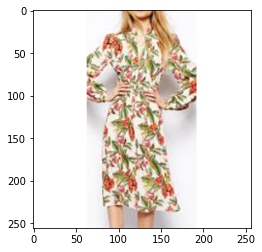

In [ ]:
sample_index = np.random.randint(20000)
image = format_image(sample_index)


plt.imshow(image)

In [ ]:
# fig, axs = plt.subplots(24,10,figsize=(30,100))
# for i in range(24):
#     for j in range(10):
#         index = data_full[data_full[attr_names_list[i]]==1].sample(1).index._data[0]
#         img = format_image(index)
#         img = axs[i][j].imshow(img)
#         axs[i][j].title.set_text(attr_names_list[i])

# Attribute model testing 

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

## Without image augmentation

In [ ]:
def format_image_model(img_name,box_x1,box_y1,box_x2,box_y2): # format image
    full_path = PATH_IMG+img_name

    
    # LOAD IMAGES:
    img = cv2.imread(full_path) # open image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # CROP IMAGES:
    cropped = Image.fromarray(img[box_y1:box_y2, box_x1:box_x2]) # crop image using box
    
    # PAD IMAGES:
    cropped_pad = ImageOps.pad(cropped,(256,256),color=(255,255,255)) # pad image to (256,256) with white background

    cropped_pad_array = np.asarray(cropped_pad)
    
    return cropped_pad_array

### Fabric

In [ ]:
fabric_data = data_full.iloc[:,np.r_[0,18:24,27:31]] # select all attributes related to fabric

In [ ]:
fabric_X_names = fabric_data.iloc[:,np.r_[0,7,8,9,10]]

In [ ]:
fabric_X_train = np.array([format_image_model(fabric_X_name[0], *fabric_X_name[1:]) for fabric_X_name in tqdm(fabric_X_names.values)])




  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
fabric_X_train.shape

In [ ]:
fabric_y_train = fabric_data.iloc[:,1:7]

In [ ]:
fabric_y_train.shape

In [ ]:
fabric_X_train, fabric_X_test, fabric_y_train, fabric_y_test = train_test_split(fabric_X_train, fabric_y_train, test_size =0.2,random_state=2)


In [ ]:
fabric_X_train.shape

In [ ]:
fabric_X_train, fabric_X_val, fabric_y_train, fabric_y_val = train_test_split(fabric_X_train, fabric_y_train, test_size =0.2,random_state=2)


#### Baseline model

In [ ]:
def initialize_model():
  model = Sequential()
  model.add(layers.Conv2D(16, (4,4), input_shape=fabric_X_train[0].shape, padding='valid', activation="relu"))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))
  model.add(layers.Conv2D(32, (3,3), padding='valid', activation="relu"))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))
  model.add(layers.Conv2D(64, (2,2), input_shape=fabric_X_train[0].shape, padding='valid', activation="relu"))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(60,activation='relu'))
  model.add(layers.Dense(6, activation = 'softmax'))
  model.summary()
  return model

In [ ]:
model = initialize_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[Recall(), Precision(), Accuracy()],
)

In [ ]:
es = EarlyStopping(patience=20,  restore_best_weights=True)

history = model.fit(fabric_X_train, np.array(fabric_y_train), epochs=50, validation_data=(fabric_X_val,fabric_y_val), batch_size=16, callbacks=[es])

In [ ]:
model.evaluate(fabric_X_test,fabric_y_test)

In [ ]:
plot_loss_accuracy(history)


#### VGG16

In [ ]:
# Training image size --> (256,256,3)

In [ ]:
model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=fabric_X_train[0].shape) # include top removes classification layer from imagenet dataset
model_vgg16.trainable = False # not trainable weights

## Preprocessing input (normalise data for VGG16 model):
fabric_X_train = preprocess_input(fabric_X_train) 
fabric_X_val = preprocess_input(fabric_X_val)
fabric_X_test = preprocess_input(fabric_X_test)


In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(60, activation='relu')
dense_layer_2 = layers.Dense(30, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([
    model_vgg16,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['recall','precision','accuracy'],
)


es = EarlyStopping(monitor='val_recall', patience=20,  restore_best_weights=True)

history = model.fit(fabric_X_train, fabric_y_train, epochs=50, validation_data=fabric_X_val, batch_size=32, callbacks=[es])

## With image augmentation

In [ ]:
fabric_data_augment = data_full.iloc[:,np.r_[0,18:24,27:31]] # select all attributes related to fabric
fabric_data_augment

,img,denim,chiffon,cotton,leather,faux,knit,x_1,y_1,x_2,y_2
0,Sweet_Crochet_Blouse/img_00000070.jpg,0,1,0,0,0,0,66,75,241,293
1,Classic_Pencil_Skirt/img_00000010.jpg,0,0,1,0,0,0,65,88,132,218
2,Strapless_Diamond_Print_Dress/img_00000038.jpg,0,0,1,0,0,0,75,43,176,300
3,Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...,1,0,0,0,0,0,64,1,129,273
4,Zippered_Single-Button_Blazer/img_00000078.jpg,0,0,1,0,0,0,1,12,257,300
...,...,...,...,...,...,...,...,...,...,...,...
19995,Embroidered_Peasant_Tank/img_00000044.jpg,0,0,1,0,0,0,93,53,160,136
19996,Tasmanian_Devil_Sweater/img_00000048.jpg,0,0,0,0,0,1,38,74,196,261
19997,Lace-Sleeved_Raglan_Henley/img_00000022.jpg,0,0,1,0,0,0,99,51,136,172
19998,Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg,0,0,1,0,0,0,57,36,158,268


In [ ]:
fabric_mean = round(fabric_data_augment.iloc[:,1:7].apply(pd.value_counts).iloc[1,:].mean())
fabric_mean

3333

In [ ]:
fabric_attrs = list(fabric_data_augment.iloc[:,1:7].apply(pd.value_counts).iloc[1,:].items())
fabric_attrs

[('denim', 1194),
 ('chiffon', 2885),
 ('cotton', 13604),
 ('leather', 406),
 ('faux', 189),
 ('knit', 1722)]

In [ ]:
def format_image_model(img_name,box_x1,box_y1,box_x2,box_y2): # format image
    full_path = PATH_IMG+img_name
    
    # LOAD IMAGES:
    img = Image.open(full_path)
  
    # CROP IMAGES:
    cropped = img.crop((box_x1, box_y1, box_x2, box_y2))
    
    # PAD IMAGES:
    cropped_pad = ImageOps.pad(cropped,(256,256),color=(255,255,255)) # pad image to (256,256) with white background

    cropped_pad_array = np.asarray(cropped_pad)
    
    return cropped_pad_array

In [ ]:
fabric_data_augment_array = pd.DataFrame()
for  attr, count in fabric_attrs:

  if count >= fabric_mean: # if number of samples is greater than mean number of samples for 'attr'
    print(attr)
    sample_df = fabric_data_augment[fabric_data_augment[attr]==1].sample(fabric_mean,random_state=2)
    sample_df['img'] = sample_df.apply(lambda row: format_image_model(row[0], *row[7:]),axis=1)
    sample_df = sample_df.iloc[:,:7]
  else:
    print(attr)
    sample_values = [0]*count
    remaining_sum = fabric_mean-count
    i = 0
    while remaining_sum != 0:
      sample_values[i]+=1
      remaining_sum-=1
      i = (i+1)%len(sample_values)
    sample_df = pd.DataFrame()
    for index, row in enumerate(fabric_data_augment[fabric_data_augment[attr]==1].values):
      sample = sample_values[index]
      cropped_img_array = format_image_model(row[0], *row[7:])
      temp_oversample_df = pd.concat([pd.DataFrame([row], columns = fabric_data_augment.columns).iloc[:,:7]]*(sample+1),ignore_index=True)
      temp_oversample_df.iloc[0,0] = [cropped_img_array]
      if sample != 0:
        augmented_img_array = augment(cropped_img_array,sample)
        temp_oversample_df.iloc[1:,0] = augmented_img_array
      sample_df = pd.concat([sample_df,temp_oversample_df],axis=0)
  fabric_data_augment_array = pd.concat([fabric_data_augment_array,sample_df],axis=0)

denim
chiffon
cotton
leather
faux
knit


In [ ]:
fabric_data_augment_array

,img,denim,chiffon,cotton,leather,faux,knit
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,0,0,0,0,0
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,0,0,0,0,0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,0,0,0,0,0
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,0,0,0,0,0
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1,0,0,0,0,0
...,...,...,...,...,...,...,...
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,0,0,0,0,1
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,0,0,0,0,1
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,0,0,0,0,1
0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0,0,0,0,0,1


In [ ]:
img_t = fabric_data_augment_array.iloc[37,0]

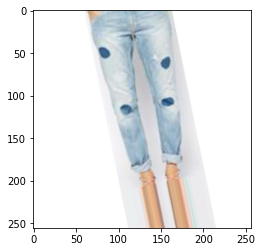

In [ ]:
plt.imshow(img_t)

In [ ]:
def augment(img_array, samples):
  img_array = img_array.reshape((1,) + img_array.shape)

  # AUGMENT IMAGES:

  # Create an ImageDataGenerator object with the desired transformations
  datagen = ImageDataGenerator(
      horizontal_flip=True,
      width_shift_range=0.2, 
      rotation_range=15,
      fill_mode='constant',
      cval=255
  )

  aug_iter = datagen.flow(img_array, batch_size=1)
  arrays = [aug_iter.next()[0].astype('uint8') for i in range (samples)]
  return arrays

In [ ]:
def display_augmented():
  sample_index = np.random.randint(20000)
  img = format_image(sample_index)
  img_array = np.asarray(img)
  img_array = img_array.reshape((1,) + img_array.shape)

  # AUGMENT IMAGES:

  # Create an ImageDataGenerator object with the desired transformations
  datagen = ImageDataGenerator(
      horizontal_flip=True,
      width_shift_range=0.2, 
      rotation_range=15,
      fill_mode='constant',
      cval=255
  )

  aug_iter = datagen.flow(img_array, batch_size=1)

  # generate samples and plot
  fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

  # generate batch of images
  for i in range(5):

    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
  
    # plot image
    ax[i].imshow(image)
    ax[i].axis('off')

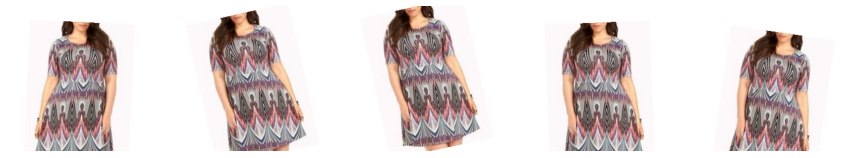

In [ ]:
display_augmented()

In [ ]:
fabric_y_train.apply(pd.value_counts).iloc[1,:]

denim       737
chiffon    1840
cotton     8737
leather     263
faux        115
knit       1108
Name: 1, dtype: int64

In [ ]:
def format_image_model(img_name,box_x1,box_y1,box_x2,box_y2): # format image
    full_path = PATH_IMG+img_name

    
    # LOAD IMAGES:
    img = cv2.imread(full_path) # open image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # CROP IMAGES:
    cropped = Image.fromarray(img[box_y1:box_y2, box_x1:box_x2]) # crop image using box
    
    # PAD IMAGES:
    cropped_pad = ImageOps.pad(cropped,(256,256),color=(255,255,255)) # pad image to (256,256) with white background

    cropped_pad_array = np.asarray(cropped_pad)
    
    return cropped_pad_array

### Fabric

In [ ]:
fabric_data = data_full.iloc[:,np.r_[0,18:24,27:31]] # select all attributes related to fabric

In [ ]:
fabric_X_names = fabric_data.iloc[:,np.r_[0,7,8,9,10]]

In [ ]:
fabric_X_train = np.array([format_image_model(fabric_X_name[0], *fabric_X_name[1:]) for fabric_X_name in tqdm(fabric_X_names.values)])



  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
fabric_X_train.shape

(20000, 256, 256, 3)

In [ ]:
fabric_y_train = fabric_data.iloc[:,1:7]

In [ ]:
fabric_y_train.shape

(20000, 6)

In [ ]:
fabric_X_train, fabric_X_test, fabric_y_train, fabric_y_test = train_test_split(fabric_X_train, fabric_y_train, test_size =0.2,random_state=2)


In [ ]:
fabric_X_train.shape

(16000, 256, 256, 3)

In [ ]:
fabric_X_train, fabric_X_val, fabric_y_train, fabric_y_val = train_test_split(fabric_X_train, fabric_y_train, test_size =0.2,random_state=2)


#### Baseline model

In [ ]:
def initialize_model():
  model = Sequential()
  model.add(layers.Conv2D(16, (4,4), input_shape=fabric_X_train[0].shape, padding='valid', activation="relu"))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))
  model.add(layers.Conv2D(32, (3,3), padding='valid', activation="relu"))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))
  model.add(layers.Conv2D(64, (2,2), input_shape=fabric_X_train[0].shape, padding='valid', activation="relu"))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(60,activation='relu'))
  model.add(layers.Dense(6, activation = 'softmax'))
  model.summary()
  return model

In [ ]:
model = initialize_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[Recall(), Precision(), Accuracy()],
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 253, 253, 16)      784       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 61, 61, 64)        8256      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)      

In [ ]:
es = EarlyStopping(patience=20,  restore_best_weights=True)

history = model.fit(fabric_X_train, np.array(fabric_y_train), epochs=50, validation_data=(fabric_X_val,fabric_y_val), batch_size=16, callbacks=[es])

Epoch 1/50
800/800 [==============================] - 25s 21ms/step - loss: 6.1028 - recall: 0.5404 - precision: 0.6833 - accuracy: 0.0107 - val_loss: 0.9472 - val_recall: 0.5475 - val_precision: 0.7355 - val_accuracy: 0.0000e+00
Epoch 2/50
800/800 [==============================] - 16s 21ms/step - loss: 0.8283 - recall: 0.6342 - precision: 0.7374 - accuracy: 0.0000e+00 - val_loss: 0.9811 - val_recall: 0.5575 - val_precision: 0.6901 - val_accuracy: 0.0000e+00
Epoch 3/50
800/800 [==============================] - 16s 21ms/step - loss: 0.6289 - recall: 0.7152 - precision: 0.7953 - accuracy: 1.3021e-04 - val_loss: 1.0441 - val_recall: 0.5863 - val_precision: 0.6763 - val_accuracy: 5.2083e-05
Epoch 4/50
800/800 [==============================] - 16s 20ms/step - loss: 0.4692 - recall: 0.7915 - precision: 0.8446 - accuracy: 6.7708e-04 - val_loss: 1.2102 - val_recall: 0.6097 - val_precision: 0.6560 - val_accuracy: 1.5625e-04
Epoch 5/50
800/800 [==============================] - 16s 20ms/step 

In [ ]:
model.evaluate(fabric_X_test,fabric_y_test)

125/125 [==============================] - 2s 14ms/step - loss: 0.9606 - recall: 0.5238 - precision: 0.7292 - accuracy: 0.0000e+00


[0.960598886013031, 0.5237500071525574, 0.729202926158905, 0.0]

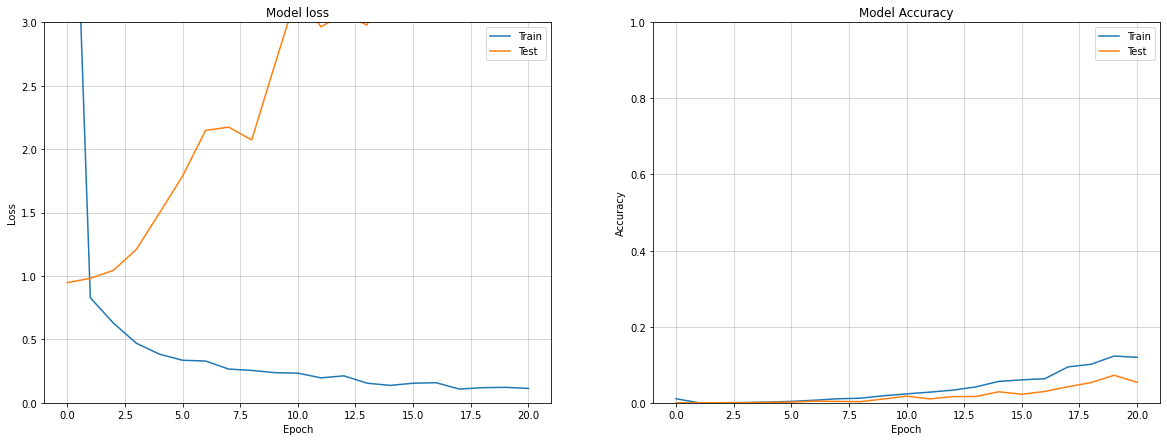

In [ ]:
plot_loss_accuracy(history)


#### VGG16

In [ ]:
# Training image size --> (256,256,3)

In [ ]:
model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=fabric_X_train[0].shape) # include top removes classification layer from imagenet dataset
model_vgg16.trainable = False # not trainable weights

## Preprocessing input (normalise data for VGG16 model):
fabric_X_train = preprocess_input(fabric_X_train) 
fabric_X_val = preprocess_input(fabric_X_val)
fabric_X_test = preprocess_input(fabric_X_test)


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(60, activation='relu')
dense_layer_2 = layers.Dense(30, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([
    model_vgg16,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['recall','precision','accuracy'],
)


es = EarlyStopping(monitor='val_recall', patience=20,  restore_best_weights=True)

history = model.fit(fabric_X_train, fabric_y_train, epochs=50, validation_data=fabric_X_val, batch_size=32, callbacks=[es])